# Package Inclusion
* Sympy :: To define the set of nonlinear equations
* Numpy :: For iterative solver
* Scipy :: To use Linear solver
* Matplotlib :: For Basin figure

In [1]:
import sympy as sy;
import numpy as np;
from numpy import cos,sin,pi;
from scipy import linalg;
import matplotlib.pyplot as plt;

# Parameter Setup
For the W4 method, we define
* dim : dimension of system
* dtau : $\Delta\tau$ for evolution
* errmax : Criterion of error to stop iteration
* itermax : Maximum iteration.

In [2]:
dim=2;

In [3]:
dtau=0.5;
errmax = pow(10,-4);
itermax = pow(10,3);

In [4]:
### Variables
### x[0], x[1], x[2], x[3], ... , x[dim-1]
### 
x = []
for i in range(dim):
    vname = 'x[' + str(i) +']';
    x.append(sy.symbols(vname));

# Definition of Source in the Sympy style
* **F**(**x**) : System of nonlinear equations
* |**F**(**x**)| : Absolute components
* J : Jacobian matrix $\partial$ **F** / $\partial$ **x**

In [5]:
### Source
### f[0], f[1], f[2], ... , f[dim-1]
f = [];
f.append( (x[0]**2 +x[1]**2 -4) );
f.append( (x[0]**2*x[1] -1) );

In [6]:
# input source
def calc_source(x,f):

### Summation of absolute values of all terms in each equation
###  to compare the error with the typical value of each equation
    fa = [];
    for j in range(dim):
        tmp = 0;
        for i in range(len(f[j].args)):
            tmp = tmp + abs(f[j].args[i]);
        fa.append(tmp);        

### Definition of variables, sources, absolute sources(x, F, |F|) as vector
    v = sy.Matrix([x]).transpose();
    F = sy.Matrix([f]).transpose();
    Fa = sy.Matrix([fa]).transpose();
    
### Analytic calculation of Jacobian(dim x dim Matrix)
    J = sy.Matrix();
    for i in range(dim):
        J = J.col_insert(i,F.diff(x[i]));    

### From Sympy to Numpy
    arg = v.transpose();
    vn = sy.lambdify(arg, v, "numpy")
    Fn = sy.lambdify(arg, F, "numpy")
    Fan = sy.lambdify(arg, Fa, "numpy")
    Jacn = sy.lambdify(arg, J, "numpy")        
        
    return vn,Fn,Fan,Jacn;

In [7]:
vn, Fn, Fan, Jacn = calc_source(x,f);

# Problem we want to solve

* Find the points where two curves cross
* There are four solutions from the figure below.

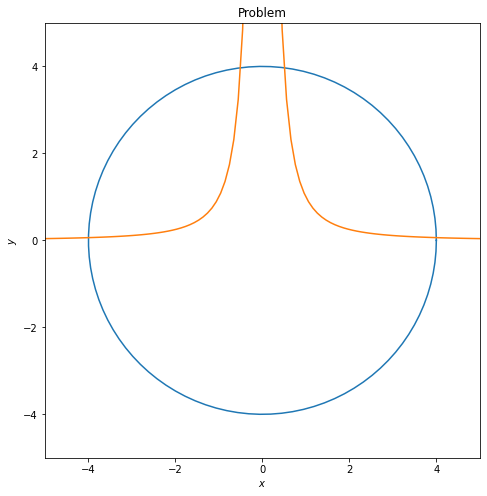

In [8]:
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(1,1,1);

theta = np.linspace(0,2.0*pi,100);
x1 = 4.0*cos(theta);
y1 = 4.0*sin(theta);
ax.plot(x1,y1);
x2 = np.linspace(-5.,5.,100);
y2 = 1./x2**2;
ax.plot(x2,y2);
ax.set_xlabel("$x$");
ax.set_ylabel("$y$");
ax.set_xlim(-5,5);
ax.set_ylim(-5,5);
ax.set_aspect('equal');
ax.set_title("Problem");


# Definition :: Newton-Raphson method

In [9]:
### NR method
def nrlu(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x as v0
#    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

### Main iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into U and L
        P, L, U = linalg.lu(J0);
        srcx = -linalg.solve(U,linalg.solve(L,linalg.solve(P,F0)));

### Increment of x
        v0 = v0 +srcx*dt;
        
    return v0, i, err

# Definition :: W4UL method

In [10]:
### W4 method with UL decomposition
def w4ul(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x and p as v0 and p0
    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

### Main iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into U and L
        Jinv = linalg.inv(J0);
        P, L, U = linalg.lu(Jinv.transpose());
        srcp = -2*p0 -U.dot(P.dot(F0));
        srcx = L.dot(p0);

### Increment of x and p
        v0 = v0 +srcx*dt;
        p0 = p0 +srcp*dt;
        
    return v0, i, err

# Definition :: W4LH method

In [11]:
### W4 method with LH decomposition
def w4lh(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x and p as v0 and p0
    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

### Main Iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into L and H
        Q, R = linalg.qr(J0.transpose());
        srcp = -2*p0 -linalg.solve(R.transpose(),F0);
        srcx = Q.dot(p0);
        v0 = v0 +srcx*dt;
        p0 = p0 +srcp*dt;
        
    return v0, i, err

# Results by Newton-Raphson method

In [12]:
### Output data for Basin Plot by the W4UL
dtau=1.;
errmax = pow(10,-4);
itermax = pow(10,3);

### Number of Division(Resolution for Basin Plot)
ND=20
xd_nr = np.array([]);
yd_nr = np.array([]);
zd_nr = np.array([]);
wd_nr = np.array([]);

for i in range(ND):
    for j in range(ND):

### Initial guess
        vini = np.array([]);
        x0 = (i+0.5)*10./ND -5.;
        y0 = (j+0.5)*10./ND -5.;
        vini = np.append(vini, x0);
        vini = np.append(vini, y0);

### Nonlinear Solver by the Newton-Raphson method
        vans, iter, err = nrlu(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Save data
        wd_nr = np.append(wd_nr,iter);
        xd_nr = np.append(xd_nr,x0);
        yd_nr = np.append(yd_nr,y0);
        if(iter>=(itermax-1)):
            zd_nr = np.append(zd_nr,0);
        else:
            zd_nr = np.append(zd_nr,vans[0]);

# Results by W4UL method

In [13]:
### Output data for Basin Plot by the W4UL
dtau=0.5;
errmax = pow(10,-4);
itermax = pow(10,3);

### Number of Division(Resolution for Basin Plot)
ND=20
xd_w4ul = np.array([]);
yd_w4ul = np.array([]);
zd_w4ul = np.array([]);
wd_w4ul = np.array([]);

for i in range(ND):
    for j in range(ND):

### Initial guess
        vini = np.array([]);
        x0 = (i+0.5)*10./ND -5.;
        y0 = (j+0.5)*10./ND -5.;
        vini = np.append(vini, x0);
        vini = np.append(vini, y0);

### Nonlinear Solver by the W4 method with the UL decomposition 
        vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Save data
        wd_w4ul = np.append(wd_w4ul,iter);
        xd_w4ul = np.append(xd_w4ul,x0);
        yd_w4ul = np.append(yd_w4ul,y0);
        if(iter>=(itermax-1)):
            zd_w4ul = np.append(zd_w4ul,0);
        else:
            zd_w4ul = np.append(zd_w4ul,vans[0]);

# Results by W4LH method

In [14]:
### Output data for Basin Plot by the W4UL
dtau=0.5;
errmax = pow(10,-4);
itermax = pow(10,3);

### Number of Division(Resolution for Basin Plot)
ND=20
xd_w4lh = np.array([]);
yd_w4lh = np.array([]);
zd_w4lh = np.array([]);
wd_w4lh = np.array([]);

for i in range(ND):
    for j in range(ND):

### Initial guess
        vini = np.array([]);
        x0 = (i+0.5)*10./ND -5.;
        y0 = (j+0.5)*10./ND -5.;
        vini = np.append(vini, x0);
        vini = np.append(vini, y0);

### Nonlinear Solver by the W4 method with the LH decomposition 
        vans, iter, err = w4lh(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Save data
        wd_w4lh = np.append(wd_w4lh,iter);
        xd_w4lh = np.append(xd_w4lh,x0);
        yd_w4lh = np.append(yd_w4lh,y0);
        if(iter>=(itermax-1)):
            zd_w4lh = np.append(zd_w4lh,0);
        else:
            zd_w4lh = np.append(zd_w4lh,vans[0]);

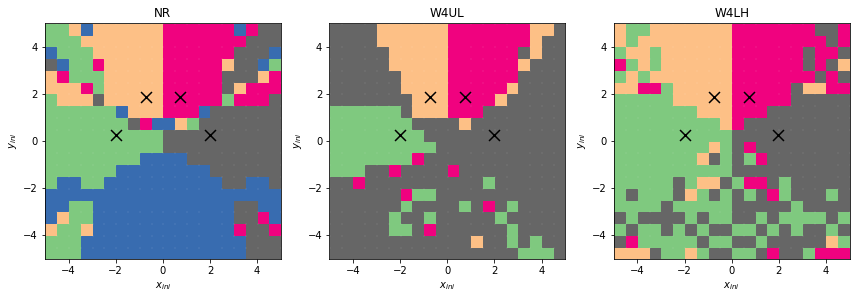

In [15]:
### Plot Basins for Newton-Raphson, W4UL, and W4LH methods

### Four solutions for plots
solx = np.array([]);
soly = np.array([]);

x0=-5.0
y0= 0.5
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

x0=-0.5
y0= 5.0
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

x0=0.5
y0=5.0
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

x0=5.0
y0=0.5
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

### Basin Figures
fig = plt.figure(figsize=(12,5));
ax1 = fig.add_subplot(1,3,1);
ax1.scatter(xd_nr,yd_nr,s=120,c=zd_nr,marker='s',cmap='Accent');
ax1.set_xlabel("$x_{ini}$");
ax1.set_ylabel("$y_{ini}$");
ax1.set_xlim(-5,5);
ax1.set_ylim(-5,5);
ax1.set_aspect('equal');
ax1.scatter(solx,soly,s=120,c='black',marker='x');
ax1.set_title("NR");

ax2 = fig.add_subplot(1,3,2);
ax2.scatter(xd_w4ul,yd_w4ul,s=120,c=zd_w4ul,marker='s',cmap='Accent');
ax2.set_xlabel("$x_{ini}$");
ax2.set_ylabel("$y_{ini}$");
ax2.set_xlim(-5,5);
ax2.set_ylim(-5,5);
ax2.set_aspect('equal');
ax2.scatter(solx,soly,s=120,c='black',marker='x');
ax2.set_title("W4UL");

ax3 = fig.add_subplot(1,3,3);
ax3.scatter(xd_w4lh,yd_w4lh,s=120,c=zd_w4lh,marker='s',cmap='Accent');
ax3.set_xlabel("$x_{ini}$");
ax3.set_ylabel("$y_{ini}$");
ax3.set_xlim(-5,5);
ax3.set_ylim(-5,5);
ax3.set_aspect('equal');
ax3.scatter(solx,soly,s=120,c='black',marker='x');
ax3.set_title("W4LH");

fig.tight_layout();


# Comments on Basin figures

## How to see the figures
* $x_{ini}$, $y_{ini}$ :: x[0], x[1]
* Black Crosses :: Four solutions to the system of nonlinear equations 
* Color difference :: Different solution which the method finds from the initial guess
* Blue color :: method fails to find any solution

## What we can see
* Newton-Raphson method sometimes fails to find a solution as a well-known fact, while w4 method can do it for this problem. (Blue color disappears.)
* All methods have the local convergence. (Initial guess close to the solution reaches it.)
* Which solution we can obtain by the W4 method strongly depends on how to decompose the Jacobian matrix, W4UL or W4LH. (Note that the Python version of W4UL decomposition is different from the FORTRAN90 version in the original paper by the permutation matrix.) 